## Attempting to implement Cody Ross's R HydRun package (v0.0.1.0; 2021 update)

https://rdrr.io/github/codyalbertross/HydRun/

This is an R implementation of a function from the MATLAB toolbox HydRun. I'm seeing how baseflow separation results of running these functions with Dustin Kincaid's 2014-2018 dataset against his MATLAB HydRun output (I have the output, nothing else).

References:

- Tang, W., & Carey, S. K. (2017). _HydRun: a MATLAB toolbox for rainfall runoff analysis._ Hydrological Processes, 31(15), 2670-2682.

- Fuka, D. R., Walter, M. T., Archibald, J. A., Steenhuis, T. S., Easton, Z. M., Fuka, M. D., & KeepSource, T. R. U. E. (2014). Package EcoHydRology. 

### Install:

`install.packages("remotes")`
`remotes::install_github("codyalbertross/HydRun")`

### Install log from 2024-08-05:
Installing package into ‘~//R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)

Downloading GitHub repo codyalbertross/HydRun@HEAD

Running `R CMD build`...

* checking for file ‘/tmp/RtmprYZiPr/remotes1170c36d67ec2/codyalbertross-HydRun-a6f7d12/DESCRIPTION’ ... OK
* preparing ‘HydRun’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘HydRun_0.0.1.0.tar.gz’

Installing package into ‘/home/millieginty/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)

### Testing R HydRun's baseflow separation and event delineation

1. `separate.baseflow` function is used to separate a stream hydrograph into baseflow and stormflow components. 

### Arguments

| argument   |                                                                               |
|------------|-------------------------------------------------------------------------------|
| hydrograph | A stream hydrograph data frame (format is 2 columns: datetime and discharge). |
| filter     | The filter coefficient used in baseflow separation - range 0.9 - 0.95.        |
| passes     | The number of filter passes.                                                  |

### Output 

- a list containing stormflow and baseflow of hydrograph. 

------------------------------------------------------------------------------------------------

2. `extract.runoff` is the function used to delineate runoff events from a stormflow timeseries.

### Arguments

| argument     |                                                                                                                                       |
|--------------|---------------------------------------------------------------------------------------------------------------------------------------|
| stormflow    |   A stream stormflow data frame (format is 2 columns: datetime and stormflow).                                                        |
| min_diff     |   The minimum difference between the start (or end) of runoff and the runoff peak.                                                    |
| return_ratio |   Determines where runoff terminates: runoff is terminated when it declines below a dynamic threshold (peak discharge)*return_ratio.  |
| b_slope      |   The beginning slope (slope threshold used to cut flat head).                                                                        |
| e_slope      |   The ending slope (slope threshold to end event).                                                                                    |
| sc           |   The smoothing coefficient, which determines the number of passes applied to stormflow.                                              |
| min_dur      |   The minimum duration of a runoff event, expressed as the number of timesteps.                                                       |
| dyslp        |   The dynamic slope threshold used to cut the flat head and end the runoff event.                                                     |

### Output 

- a list containing stormflow and baseflow of hydrograph. 

### Data

I set up data input and analysis output in this HydRun directory. Going to try this baseflow separation test using a copy of the Millar example data from FD-36 (upland rural watershed of 39.7 ha, located in eastern Pennsylvania) that's just Q and c (`FD36_ExampleData_NO3_ppm.csv`).

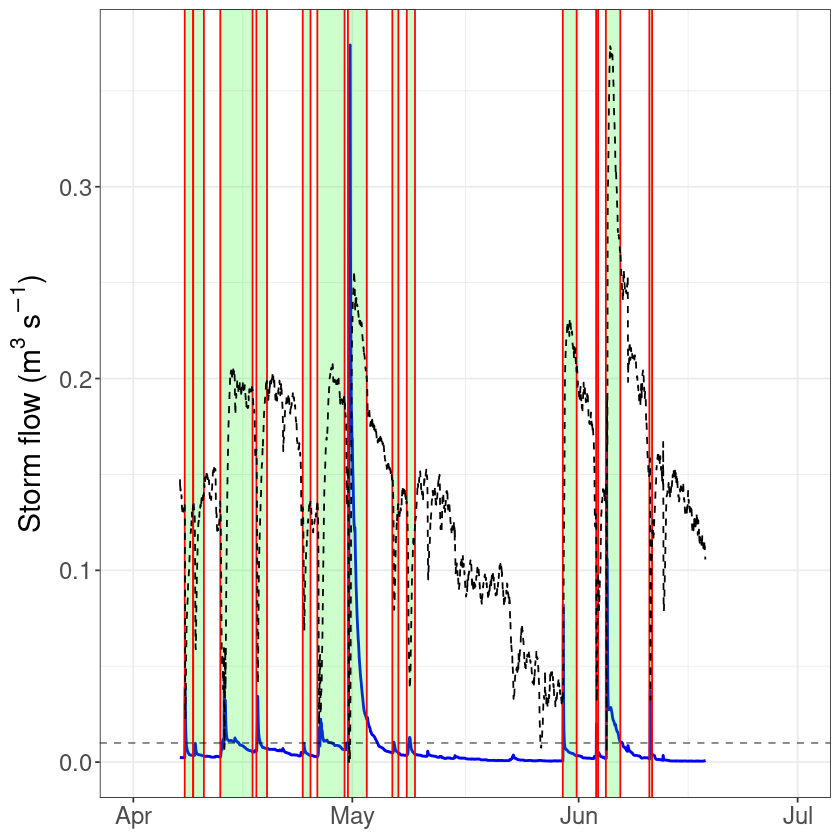

In [91]:
#################
# LOAD PACKAGES #
#################

library(tidyverse)
library(dplyr)
library(HydRun)

###################
# SET DIRECTORIES #
###################

input_dir <- "~//OneDrive/git-repos/cQ_analysis/hydrun/data"
output_dir <- "~//OneDrive/git-repos/cQ_analysis/hydrun/output/"

################
# READ IN DATA #
################

# read in the example data from Millar et al 2021
hydrograph <- read.csv(file.path(input_dir, "FD36_ExampleData_NO3_ppm.csv")) %>%
   mutate(datetime = as.POSIXct(datetime, format = "%m/%d/%Y %H:%M", tz = "EST"))

# rescale the data - not really important for this example just for plotting event delin in #4 below
hydrograph <- hydrograph %>% 
  mutate(rescaled_conc = ((conc-min(conc))/(max(conc)-min(conc))*max(q_cms)))

# name the input data
dataSetName = "FD36_ExampleData_NO3_ppm"

#######################
# BASEFLOW SEPARATION #
# + EVENT DELINEATION #
#######################

# using 3 baseflow separation passes as in Millar example, also 0.99 as filter parameter
hydrograph_separated <- separate.baseflow(hydrograph, filter = 0.99, passes = 3)

# apply the runoff event extraction function
# this contains the same stormflow smoothing algorithm that the Millar code appropriates

# I'm using the defaults from the Millar example
runoff_events <- extract.runoff(hydrograph_separated$stormflow, 
                                min_diff = 0.003, # Millar example had 0.01, 0.003, 0.05
                                return_ratio = 0.18, # this is what Dustin did, I don't have a sense for the ex.
                                b_slope = 0.001, 
                                e_slope = 0.35, 
                                sc = 4, # Millar example set to 4
                                min_dur = 4, # Millar example was 2 hr; I think this is the eqivalent 
                                dyslp = 0.001)

#########################
# PLOT AND SAVE RESULTS #
#########################

# 1) Plot total discharge with baseflow

baseflowHydrograph <- ggplot() + 
                            geom_line(data=hydrograph, aes(x=datetime, y=q_cms), 
                                      linewidth=0.5, color="black") +
                            geom_line(data=hydrograph_separated$baseflow, aes(x=datetime, y=baseflow), 
                                      linewidth=0.75, color = "blue") +
                            scale_color_brewer(palette = "Set1") +
                            xlab(NULL) +
                            ylab(expression(paste("Discharge (",m^3," ",s^-1,")"))) +
                            theme_bw() +
                            theme(legend.title = element_blank(),
                                  text=element_text(size=18))

ggsave(file=file.path(output_dir,"Hydrographs",paste(dataSetName,"_Baseflows.jpeg")),
       baseflowHydrograph,
       width = 14, 
       height = 4, 
       units = "in",
       dpi=600)

# 2) Plot stormflow

stormflowHydrograph <- ggplot() + 
  geom_line(data=hydrograph, aes(x=datetime, y=q_cms), 
        linewidth=0.5, color="black") +
  geom_line(data=hydrograph_separated$stormflow, aes(x=datetime, y=stormflow), 
        linewidth=0.75, color = "blue") +
  scale_color_brewer(palette = "Set1") +
  xlab(NULL) +
  ylab(expression(paste("Storm flow (",m^3," ",s^-1,")"))) +
  theme_bw() +
  theme(legend.title = element_blank(),
        text=element_text(size=18))

ggsave(file=file.path(output_dir,"Hydrographs",paste(dataSetName,"_StormflowsOnly.jpeg")),
       stormflowHydrograph,
       width = 14, 
       height = 4, 
       units = "in",
       dpi=600)

# 3a) Plot smoothed storm flows with storm flow thresholds

# Combine all event dataframes into one
all_events <- do.call(rbind, lapply(names(runoff_events$RunoffEvents), function(event) {
  df <- runoff_events$RunoffEvents[[event]]
  df$event <- event
  df
}))

# Calculate the start and end times for each event
event_times <- all_events %>%
  group_by(event) %>%
  summarise(
    start = min(datetime),
    end = max(datetime),
    duration_hrs = (end - start) / 3600
  )

stormflowThreshHydrograph <- ggplot(all_events, aes(x = datetime, y = event_stormflow, color = "0.99")) + 
  geom_line(size = 0.75) +
  scale_color_brewer(palette = "Set1") +
  geom_hline(yintercept = 0.01, linetype = "dashed", color = "black", alpha = 0.5) +
  xlab(NULL) +
  ylab(expression(paste("Storm flow (", m^3, " ", s^-1, ")"))) +
  scale_x_datetime(limits = as.POSIXct(c("2020-04-01 00:00:00", "2020-07-01 01:00:00"))) +
  theme_bw() +
  theme(legend.title = element_blank(),
        text = element_text(size = 18))

ggsave(file=file.path(output_dir,"Hydrographs",paste(dataSetName,"_StormflowsOnlyWithThresholds.jpeg")),
       stormflowThreshHydrograph,
       width = 14, 
       height = 4, 
       units = "in",
       dpi=600)

# 4) Plot stormflow with shaded event durations

eventsDataShaded1 <- ggplot() + #all_events, aes(x = datetime, y = event_stormflow, color = "0.99")) + 
  geom_line(data=hydrograph, aes(x=datetime, y=q_cms), size=0.8, color="blue") +
  geom_rect(data = event_times, aes(xmin = start, xmax = end, ymin = -Inf, ymax = Inf), 
            fill = "green", color = 'red', alpha = 0.2, inherit.aes = FALSE) +
  geom_line(data=hydrograph, aes(x=datetime, y=rescaled_conc), size=0.5, color="black",linetype="dashed") +
  geom_line(size = 0.75) +
  scale_color_brewer(palette = "Set1") +
  geom_hline(yintercept = 0.01, linetype = "dashed", color = "black", alpha = 0.5) +
  xlab(NULL) +
  ylab(expression(paste("Storm flow (", m^3, " ", s^-1, ")"))) +
  scale_x_datetime(limits = as.POSIXct(c("2020-04-01 00:00:00", "2020-07-01 01:00:00"))) +
  theme_bw() +
  theme(legend.title = element_blank(),
        text = element_text(size = 18))

ggsave(file=file.path(output_dir,"Hydrographs",paste(dataSetName,"_BatchEventSeparationPlot.jpeg")),
       eventsDataShaded1,
       width = 14, 
       height = 4, 
       units = "in",
       dpi=600)

eventsDataShaded1